<a href="https://colab.research.google.com/github/KillerStrike17/Deep-Learning-for-Vision-Using-Tensorflow-Keras/blob/master/7.%20ENAS/ENAS_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Loadinng all the required libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,concatenate, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
#Importing the database
from keras.datasets import cifar10
#splitting the database
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
#Storing the training dataset details in variables
num_train,  img_rows, img_cols,img_channels, =  train_features.shape
print("No of training dataset:- ",num_train)
print("No of rows:- ",img_rows)
print("No of columns:- ",img_cols)
print("No of channels:- ",img_channels)
#Storing the testing dataset details in variables
num_test, _, _, _ =  test_features.shape
#Stroing the total class of dataset in num_classes variable
num_classes = len(np.unique(train_labels))
print("Total Classes:- ", num_classes)

170500096/170498071 [==============================] - 2s 0us/step
No of training dataset:-  50000
No of rows:-  32
No of columns:-  32
No of channels:-  3
Total Classes:-  10


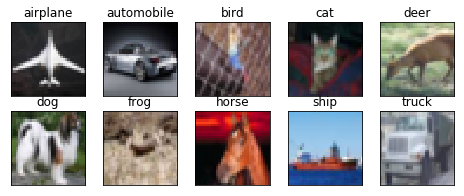

In [0]:
#class_names of the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
#loop to display a sample image of each channel
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot graphs of accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Function to calculate accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
def space_to_depth_x(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
#converting the pixel in range 0-1
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#Define the model
concat_axis = -1

model = Model()

#input Convolution
visible = Input(shape =(32, 32, 3))

#Seperable Convolution 1
sep1 = SeparableConv2D(40, 5, 5 , activation = 'relu',border_mode='same')(visible)

#Batch Normalization and Dropout
norm1 = BatchNormalization()(sep1)
drop1 = Dropout(0.25) (norm1)

#Normal Convolution 1
conv1 = Convolution2D(80, 5, 5, border_mode='same', activation = 'relu')(drop1)

#Batch Normalization and Dropout
norm2 = BatchNormalization()(conv1)
drop2 = Dropout(0.25) (norm2)

#Normal Convolution 2
conv2 = Convolution2D(80, 5, 5, border_mode='same', activation = 'relu')(drop2)

#Batch Normalization and Dropout
norm3 = BatchNormalization()(conv2)
drop3 = Dropout(0.25) (norm3)

#Skip connection 1
skip1 = concatenate([drop1, drop3], axis = concat_axis)

#Seperable Convolution 2
sep2 = SeparableConv2D(100, 5, 5 , activation = 'relu',border_mode='same')(skip1)

#Batch Normalization and Dropout
norm4 = BatchNormalization()(sep2)
drop4 = Dropout(0.25) (norm4)

#skip connection 2
skip_con1 = drop1
skip_con1 = Lambda(space_to_depth_x)(skip_con1)
skip_con2 = drop4
skip_con2 = Lambda(space_to_depth_x)(skip_con2)
skip2 = concatenate([skip_con2, skip_con1] ,axis = concat_axis)

#Transition Block 1
pool1 = MaxPooling2D(pool_size=(2, 2))(skip2)
pointwise1 = Convolution2D(40, 1, 1, border_mode='same', activation = 'relu')(pool1)

#Batch Normalization and Dropout
norm5 = BatchNormalization()(pointwise1)
drop5 = Dropout(0.25) (norm5)

#Seperable Convolution 3
sep3 = SeparableConv2D(80, 3, 3 , activation = 'relu',border_mode='same')(drop5)

#Batch Normalization and Dropout
norm6 = BatchNormalization()(sep3)
drop6 = Dropout(0.25) (norm6)

#skip connection 3
skip_con1 = Lambda(space_to_depth_x)(skip_con1)
skip_con2 = Lambda(space_to_depth_x)(skip_con2)
skip3 = concatenate([skip_con1, skip_con2, drop6], axis = concat_axis)

#Normal Convolution 3
conv3 = Convolution2D(80, 5, 5, border_mode='same', activation = 'relu')(skip3)

#Batch Normalization and Dropout
norm7 = BatchNormalization()(conv3)
drop7 = Dropout(0.25) (norm7)

#skip connection 4
skip_con3 = drop3
skip_con3 = Lambda(space_to_depth_x)(skip_con3)
skip_con3 = Lambda(space_to_depth_x)(skip_con3)
skip4 = concatenate([skip_con3, skip_con2, drop6, drop7], axis = concat_axis)

#Seperable Convolution 4
sep4 = SeparableConv2D(100, 3, 3 , activation = 'relu',border_mode='same')(skip4)

#Batch Normalization and Dropout
norm8 = BatchNormalization()(sep4)
drop8 = Dropout(0.25) (norm8)

#skip connection 5
skip5 = concatenate([skip_con3, skip_con2, drop6, drop7, drop8, skip_con1], axis = concat_axis)

#Seperable Convolution 5
sep5 = SeparableConv2D(120, 5, 5 , activation = 'relu',border_mode='same')(skip5)

#Batch Normalization and Dropout
norm9 = BatchNormalization()(sep5)
drop9 = Dropout(0.25) (norm9)

#skip connection 6
skip6 = concatenate([ drop8, drop9, skip_con1, skip_con2, drop6], axis = concat_axis)

#Transition Block 2
pool2 = MaxPooling2D(pool_size=(2, 2))(skip6)
pointwise2 = Convolution2D(40, 1, 1, border_mode='same', activation = 'relu')(pool2)

#Batch Normalization and Dropout
norm10 = BatchNormalization()(pointwise2)
drop10 = Dropout(0.25) (norm10)


#skip connection 7
skip_con4 = drop7
skip_con4 = Lambda(space_to_depth_x)(skip_con4)
skip7 = concatenate([ skip_con4, drop10], axis = concat_axis)

#Normal Convolution 4
conv4 = Convolution2D(80, 5, 5, border_mode='same', activation = 'relu')(skip7)

#Batch Normalization and Dropout
norm11 = BatchNormalization()(conv4)
drop11 = Dropout(0.25) (norm11)

#skip connection8
skip_con5 = drop2
skip_con5 = Lambda(space_to_depth_x)(skip_con5)
skip_con5 = Lambda(space_to_depth_x)(skip_con5)
skip_con5 = Lambda(space_to_depth_x)(skip_con5)
skip_con6 = drop8
skip_con6 = Lambda(space_to_depth_x)(skip_con6)
skip_con2 = Lambda(space_to_depth_x)(skip_con2)
skip8 = concatenate([ drop11, skip_con5, skip_con6, skip_con2], axis = concat_axis)

#Seperable Convolution 6
sep6 = SeparableConv2D(80, 5, 5 , activation = 'relu',border_mode='same')(skip8)
                                                                          
#Batch Normalization and Dropout
norm12 = BatchNormalization()(sep6)
drop12 = Dropout(0.25) (norm12)

#skip connection 9
skip_con7 = drop6
skip_con7 = Lambda(space_to_depth_x)(skip_con7)
skip_con3 = Lambda(space_to_depth_x)(skip_con3)
skip9 = concatenate([ drop12,drop11, skip_con3, skip_con5, skip_con7], axis = concat_axis)

#Normal Convolution 5
conv5 = Convolution2D(100, 3, 3, border_mode='same', activation = 'relu')(skip9)

#Batch Normalization and Dropout
norm13 = BatchNormalization()(conv5)
drop13 = Dropout(0.25) (norm13)
                                                                          
#skip connection 10
skip_con1 = Lambda(space_to_depth_x)(skip_con1)
skip10 = concatenate([ drop12, drop13, skip_con1, skip_con2, skip_con7, skip_con3, skip_con6], axis = concat_axis)

#Seperable Convolution 7
sep7= SeparableConv2D(120, 5, 5 , activation = 'relu',border_mode='same')(skip10)
                                                                          
#Batch Normalization and Dropout
norm14 = BatchNormalization()(sep7)
drop14 = Dropout(0.25)(norm14)

#skip connection 11
skip11 = concatenate([ drop14, drop12, skip_con2, skip_con6], axis = concat_axis)

#Output Layer
final = Convolution2D(10, 4)(skip11)
flat1 = Flatten()(final)
output = Activation('softmax')(flat1)

model = Model(inputs=visible, outputs=output)

#Summarize layers
print(model.summary())
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0625 00:39:16.059029 140003999659904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 00:39:16.093558 140003999659904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(40, (5, 5), activation="relu", padding="same")`
  if __name__ == '__main__':
W0625 00:39:16.102109 140003999659904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 00:39:16.146927 140003999659904 deprecation_wrapper.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 32, 32, 40)   235         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 40)   160         separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 40)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=390.625, validation_data=(array([[[..., verbose=1, epochs=100)`
  # Remove the CWD from sys.path while we load stuff.
W0625 00:39:20.665006 140003999659904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrap

Epoch 1/100
391/390 [==============================] - 148s 378ms/step - loss: 2.3474 - acc: 0.4268 - val_loss: 1.5351 - val_acc: 0.4865
Epoch 2/100
391/390 [==============================] - 137s 349ms/step - loss: 1.1680 - acc: 0.5948 - val_loss: 1.1737 - val_acc: 0.6007
Epoch 3/100
391/390 [==============================] - 138s 352ms/step - loss: 0.9724 - acc: 0.6608 - val_loss: 1.1605 - val_acc: 0.6354
Epoch 4/100
391/390 [==============================] - 138s 353ms/step - loss: 0.8255 - acc: 0.7133 - val_loss: 1.2253 - val_acc: 0.5914
Epoch 5/100
391/390 [==============================] - 138s 354ms/step - loss: 0.7003 - acc: 0.7588 - val_loss: 1.1130 - val_acc: 0.6480
Epoch 6/100
391/390 [==============================] - 138s 354ms/step - loss: 0.5874 - acc: 0.7939 - val_loss: 0.9266 - val_acc: 0.7012
Epoch 7/100
391/390 [==============================] - 138s 354ms/step - loss: 0.4957 - acc: 0.8254 - val_loss: 1.0477 - val_acc: 0.6844
Epoch 8/100
391/390 [====================

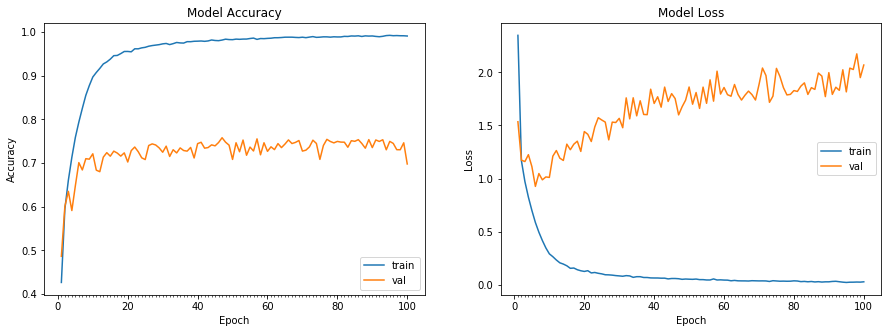

Accuracy on test data is: 69.82


In [0]:
# Training the developed model over the dataset
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 steps_per_epoch = train_features.shape[0]/128, nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))